In [30]:
import numpy as np
import pandas as pd
from scipy import stats
import operator
from yahoofinancials import YahooFinancials
from fastquant import backtest

In [31]:
# downloads data from YahooFinancials on TSLA from 2010-06 to 2020-12
ticker = 'TSLA'
yahoo = YahooFinancials(ticker)
tsla_df = yahoo.get_historical_price_data('1995-01-01', '2020-12-30', 'daily')

# formats the data into a dataframe
tsla_df = pd.DataFrame(tsla_df[ticker]['prices']).drop(['date'], axis=1).rename(columns={'formatted_date':'date'})

# only using the adjclose and using date as the index
tsla_df = tsla_df[['date','adjclose']]
tsla_df['date'] = pd.to_datetime(tsla_df['date'])
tsla_df.set_index('date', inplace=True)

In [47]:
tsla_df_train = tsla_df.loc[:'2017']
tsla_df_test = tsla_df.loc['2018':]

In [21]:
# defining a function that generates the lookback, forward dataframe
def generate_lookback_forward_pair(df, lookback, forward):
    working_df = df
    
    # create lookback and forward returns
    working_df['lookback'] = working_df['adjclose'].pct_change(lookback)
    working_df['forward'] = working_df['adjclose'].pct_change(forward)
    
    # create dates for visual checks
    working_df['lookback_from_date'] = working_df.index
    working_df['forward_from_date'] = working_df.index
    working_df = working_df.dropna()
    
    # shifts the forward df to create pairs of lookback-forward returns
    lookback_df = working_df[['lookback', 'lookback_from_date']]
    forward_df = working_df[['forward', 'forward_from_date']]
    forward_df = forward_df.shift(-forward)
    
    # merge them back together
    corr_df = lookback_df.merge(forward_df, how='left', left_index=True, right_index=True)
    
    # ensures each pair is unique
    if lookback >= forward:
        corr_df = corr_df.iloc[::forward, :]
    elif forward > lookback:
        corr_df = corr_df.iloc[::lookback, :]
    
    corr_df = corr_df.dropna()
    
    return corr_df

In [22]:
# defining a function for us to test correlation between past Y days of data and forward X days
def test_corr_lookback_forward(df, lookback, forward):
    
    # create pairs of returns of lookback-forward
    corr_df = generate_lookback_forward_pair(df, lookback, forward)
    
    # ensures we have at least 30 data points
    if len(corr_df) >= 30:
        corr_results  = stats.pearsonr(corr_df['lookback'], corr_df['forward'])
        
        return corr_results
    return (None, None)

def test_corr_many_pairs(df, range_min, range_max, step):
    
    lookbacks = range(range_min, range_max, step)
    forwards = range(range_min, range_max, step)
    
    results_list = []
    
    for lookback in lookbacks:
        for forward in forwards:
            pearson_r, p_value = test_corr_lookback_forward(df, lookback, forward)
            results_list.append([pearson_r, p_value, lookback, forward])
            
    return results_list

In [24]:
# test many pairs of lookback-forward returns, from a minimum of 5 days to 300 days, with a step of 5 between
results_list = test_corr_many_pairs(tsla_df_train, 5, 300, 5)

# remove all the (None, None) pairs where there were less than 30 data points to calculate correlaton on
results_list = [x for x in results_list if x[0] is not None]

# sort the list so that we have the highest correlation first
results_list = sorted(results_list, key=operator.itemgetter(0), reverse=True)

# print the top 10 highest correlation
results_list[:10]

[[0.26908639447027505, 0.15046285378886895, 60, 65],
 [0.26665821081034996, 0.09192843061916699, 45, 45],
 [0.26071584368354755, 0.0033186294565452443, 15, 15],
 [0.2564652574696962, 0.15651450676662576, 55, 75],
 [0.2522379602547261, 0.1787149430011884, 65, 60],
 [0.22939216972098353, 0.20661365929647094, 55, 70],
 [0.21739089970052375, 0.1514337212840689, 75, 40],
 [0.19202082993046043, 0.008468793790075566, 20, 10],
 [0.18527062388887466, 0.011351837870817732, 10, 20],
 [0.18514758086322267, 0.25272032003117634, 85, 45]]

In [27]:
results_list = [x for x in results_list if x[1] < 0.1 and x[2] != x[3]]
results_list

[[0.19202082993046043, 0.008468793790075566, 20, 10],
 [0.18527062388887466, 0.011351837870817732, 10, 20],
 [0.1685364878554015, 0.061325142054005924, 25, 15],
 [0.1576753305949152, 0.08155016001338222, 15, 25],
 [0.10158091964844781, 0.05057788314702778, 5, 20],
 [0.08696876914523485, 0.09306449677403333, 20, 5]]

In [10]:
tsla_df_test.columns = ['close']

Starting Portfolio Value: 100000.00
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
commission : 0.0075
stop_loss : None
stop_trail : None
===Strategy level arguments===
fast_period : 10
slow_period : 20
2018-02-27, BUY CREATE, 70.20
2018-02-27, Cash: 100000.0
2018-02-27, Price: 70.197998046875
2018-02-27, Buy prop size: 1412
2018-02-27, Afforded size: 1412
2018-02-27, Final size: 1412
2018-02-28, BUY EXECUTED, Price: 70.20, Cost: 99119.57, Comm: 743.40, Size: 1412.00
2018-03-13, SELL CREATE, 65.33
2018-03-14, SELL EXECUTED, Price: 65.33, Cost: 99119.57, Comm: 691.80, Size: -1412.00
2018-03-14, OPERATION PROFIT, GROSS: -6879.27, NET: -8314.47
2018-04-16, BUY CREATE, 58.24
2018-04-16, Cash: 91685.53457191467
2018-04-16, Price: 58.242000579833984
2018-04-16, Buy prop size: 1560
2018-04-16, Afforded size: 1560
2018-04-16, Final size: 1560
2018-04-17, BUY EXECUTED, Price: 58.24, Cost: 90857.52, Comm: 681.43, Size: 1560.00
2018-04-27, SELL CREATE, 58.78
2018-04-30

2020-10-06, SELL CREATE, 425.30
2020-10-07, SELL EXECUTED, Price: 425.30, Cost: 423633.60, Comm: 3317.34, Size: -1040.00
2020-10-07, OPERATION PROFIT, GROSS: 18678.39, NET: 12183.80
2020-10-07, BUY CREATE, 425.30
2020-10-07, Cash: 439633.75001417164
2020-10-07, Price: 425.29998779296875
2020-10-07, Buy prop size: 1024
2020-10-07, Afforded size: 1024
2020-10-07, Final size: 1024
2020-10-08, BUY EXECUTED, Price: 425.30, Cost: 435507.19, Comm: 3266.30, Size: 1024.00
2020-10-28, SELL CREATE, 410.83
2020-10-29, SELL EXECUTED, Price: 410.83, Cost: 435507.19, Comm: 3155.17, Size: -1024.00
2020-10-29, OPERATION PROFIT, GROSS: -14817.28, NET: -21238.76
2020-11-13, BUY CREATE, 408.50
2020-11-13, Cash: 418394.99056104664
2020-11-13, Price: 408.5
2020-11-13, Buy prop size: 1015
2020-11-13, Afforded size: 1015
2020-11-13, Final size: 1015
2020-11-16, BUY EXECUTED, Price: 408.50, Cost: 414627.50, Comm: 3109.71, Size: 1015.00
Final Portfolio Value: 632769.3541352653
Final PnL: 532769.35
Number of str

<IPython.core.display.Javascript object>


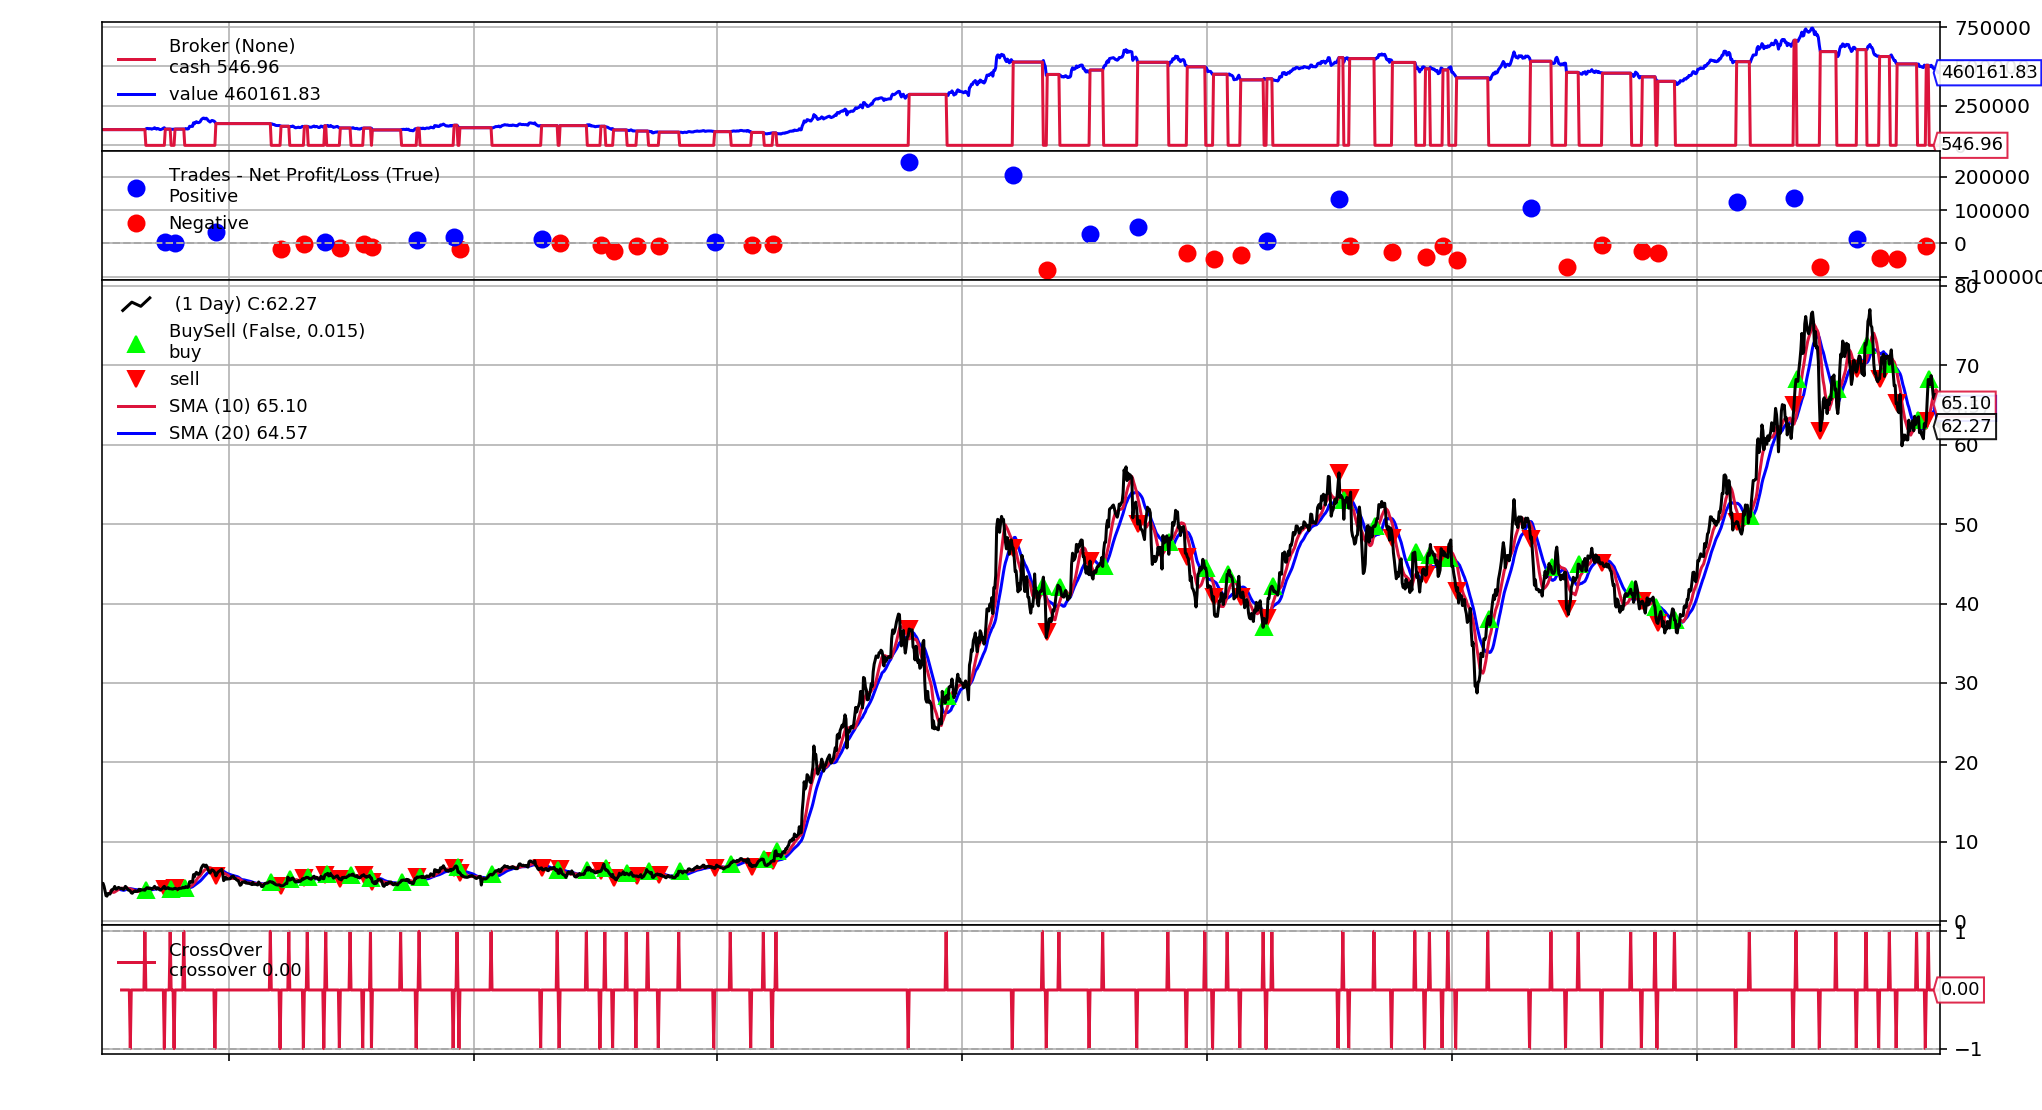

,strat_id,init_cash,buy_prop,sell_prop,commission,stop_loss,stop_trail,execution_type,channel,symbol,...,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value
0,0,100000,1,1,0.0075,None,None,close,None,None,...,86.492769,6,4.167381,27516.635132,"{'len': 477, 'drawdown': 54.29378665288925, 'm...",54.293787,477,0.682471,532769.35,632769.354135


In [11]:
backtest('smac', tsla_df_test, fast_period=10, slow_period=20)

Starting Portfolio Value: 100000.00
===Global level arguments===
init_cash : 100000
buy_prop : 1
sell_prop : 1
commission : 0.0075
stop_loss : None
stop_trail : None
===Strategy level arguments===
fast_period : 10
slow_period : 20
2018-02-27, BUY CREATE, 70.20
2018-02-27, Cash: 100000.0
2018-02-27, Price: 70.197998046875
2018-02-27, Buy prop size: 1412
2018-02-27, Afforded size: 1412
2018-02-27, Final size: 1412
2018-02-28, BUY EXECUTED, Price: 70.20, Cost: 99119.57, Comm: 743.40, Size: 1412.00
2018-03-13, SELL CREATE, 65.33
2018-03-14, SELL EXECUTED, Price: 65.33, Cost: 99119.57, Comm: 691.80, Size: -1412.00
2018-03-14, OPERATION PROFIT, GROSS: -6879.27, NET: -8314.47
2018-04-16, BUY CREATE, 58.24
2018-04-16, Cash: 91685.53457191467
2018-04-16, Price: 58.242000579833984
2018-04-16, Buy prop size: 1560
2018-04-16, Afforded size: 1560
2018-04-16, Final size: 1560
2018-04-17, BUY EXECUTED, Price: 58.24, Cost: 90857.52, Comm: 681.43, Size: 1560.00
2018-04-27, SELL CREATE, 58.78
2018-04-30

2020-11-13, BUY CREATE, 408.50
2020-11-13, Cash: 418394.99056104664
2020-11-13, Price: 408.5
2020-11-13, Buy prop size: 1015
2020-11-13, Afforded size: 1015
2020-11-13, Final size: 1015
2020-11-16, BUY EXECUTED, Price: 408.50, Cost: 414627.50, Comm: 3109.71, Size: 1015.00
Final Portfolio Value: 632769.3541352653
Final PnL: 532769.35
Number of strat runs: 1
Number of strats per run: 1
Strat names: ['smac']
**************************************************
--------------------------------------------------
{'init_cash': 100000, 'buy_prop': 1, 'sell_prop': 1, 'commission': 0.0075, 'stop_loss': None, 'stop_trail': None, 'execution_type': 'close', 'channel': None, 'symbol': None, 'allow_short': False, 'short_max': 1.5, 'add_cash_amount': None, 'add_cash_freq': 'M', 'fast_period': 10, 'slow_period': 20}
OrderedDict([('rtot', 1.8449358003028484), ('ravg', 0.002473104289950199), ('rnorm', 0.8649276915689482), ('rnorm100', 86.49276915689482)])
OrderedDict([('sharperatio', 0.6824708229979836)])

<IPython.core.display.Javascript object>


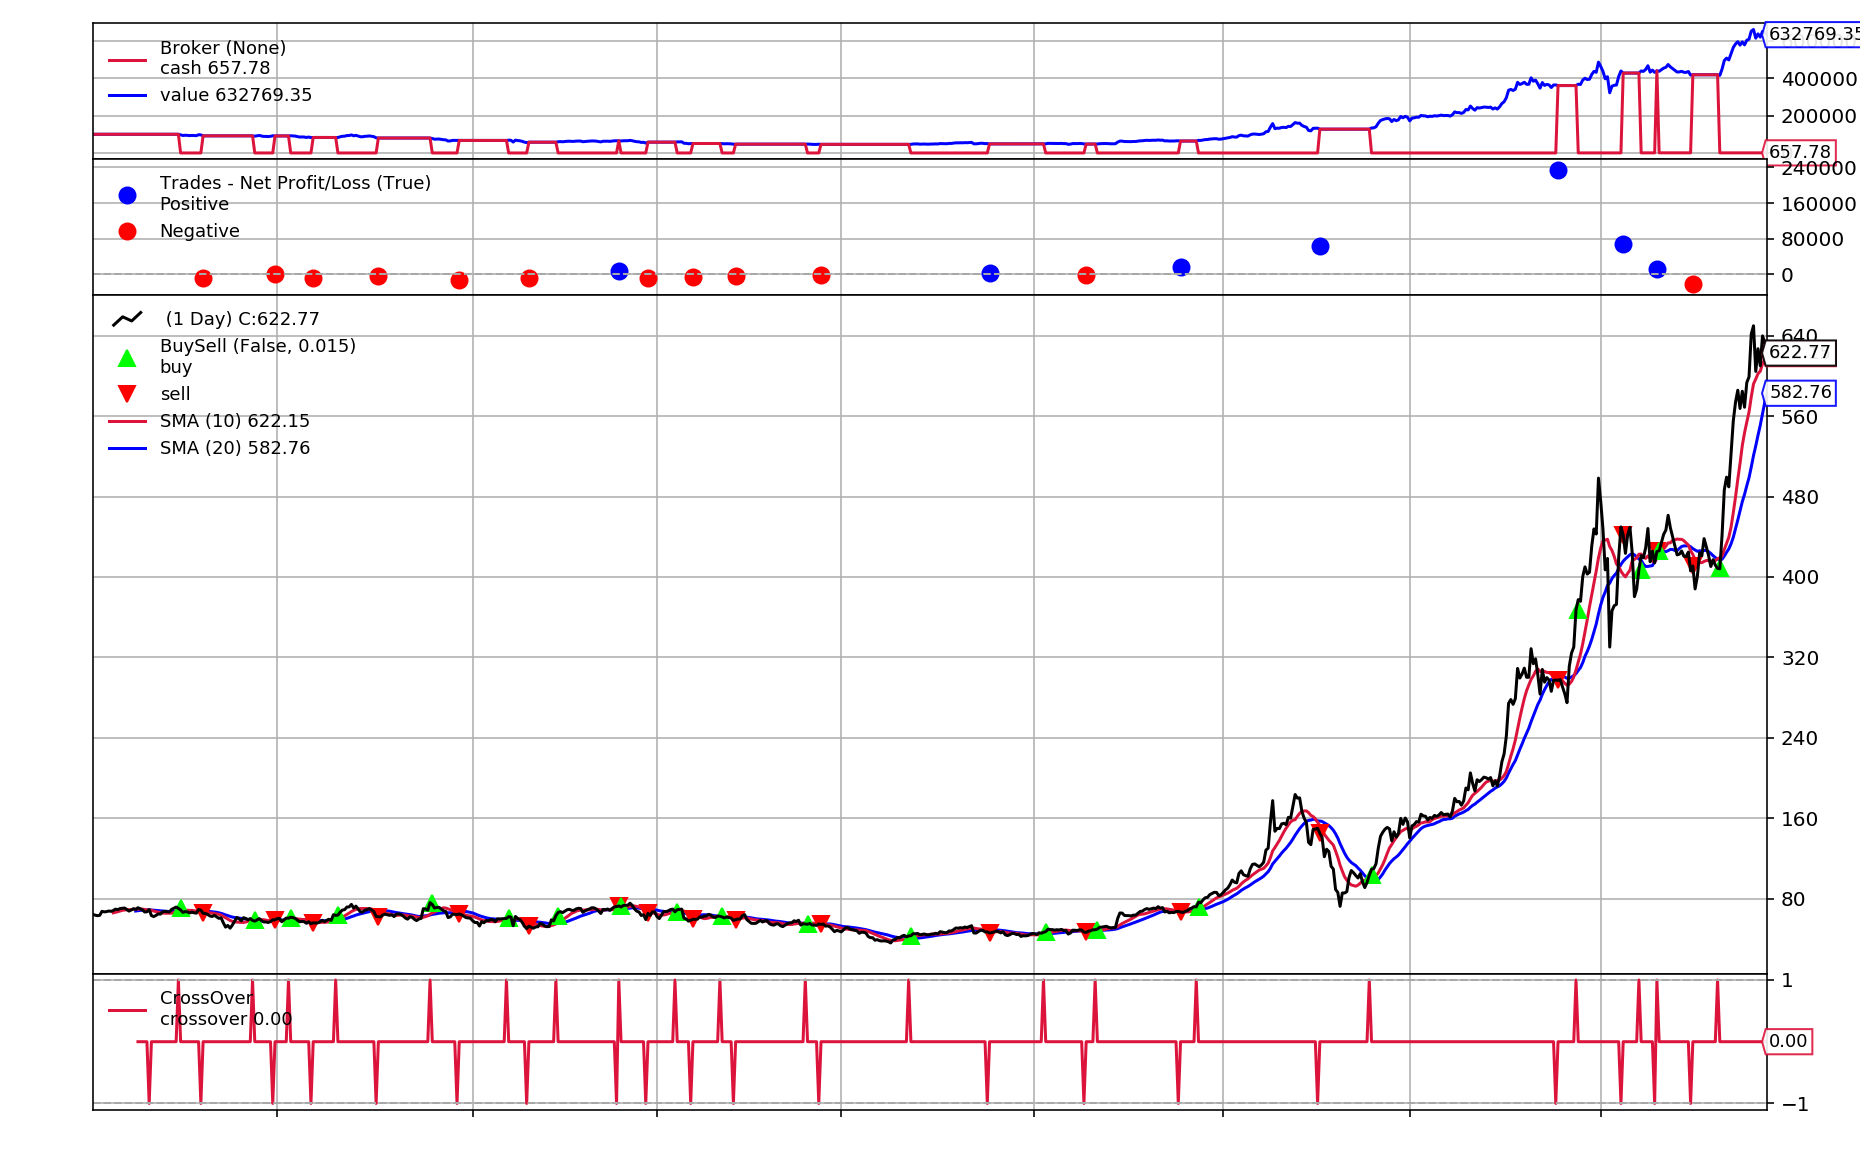

We started with a value of: [100000]
We ended with a value of: [632769.35413527]


In [54]:
# adjusting our adjusted close name to close so we can it on fastquant
tsla_df_test.columns = ['close']

# running a backtest using fastquant
results = backtest('smac', tsla_df_test, fast_period=10, slow_period=20)

# print out results
print(f'We started with a value of: {results["init_cash"].values}')
print(f'We ended with a value of: {results["final_value"].values}')

In [55]:
print(f'We started with a value of: {results["init_cash"].values[0]}.')
print(f'We ended with a value of: {round(results["final_value"].values[0], 2)}.')
print(f'Our returns were: {round((((round(results["final_value"].values[0], 2)) - (results["init_cash"].values[0]))/results["init_cash"].values[0])*100, 2)}%.')

We started with a value of: 100000.
We ended with a value of: 632769.35.
Our returns were: 532.77%.
